#                  PUC MG - Pontifícia Universiasde Católica de Minas Gerais

### Pós-Graduação em Ciência de Dados e Big Data

### TRABALHO DE CONCLUSÃO DE CURSO

### TÍTULO: CLASSIFICAÇÃO DE FAKE NEWS POR MEIO DE TÉCNICAS DE MACHINE LEARNING

### ALUNO: MOACIR DE CASTRO RIBEIRO JÚNIOR

In [2]:
import itertools
import string
import random
import pandas as pd
import numpy as np
import multiprocessing
from sklearn.utils import shuffle
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from wordcloud import WordCloud
import nltk
import pickle
import matplotlib.pyplot as plt

### Carregando a primeira base de dados

In [5]:
df_1 = pd.read_csv('dados/news.csv')
df_1.shape

(6335, 4)

In [6]:
df_1.loc[(df_1['label'] == 1) , ['label']] = "FAKE"
df_1.loc[(df_1['label'] == 0) , ['label']] = "REAL"

In [7]:
df_1.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [8]:
df_1.duplicated().value_counts()

False    6335
dtype: int64

In [9]:
df_1.label.value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

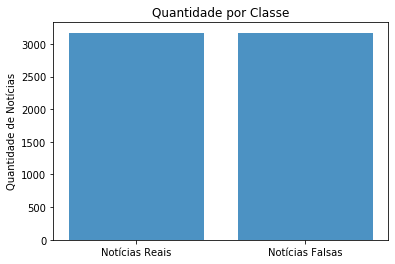

In [10]:
classes = ('Notícias Reais', 'Notícias Falsas')
y_pos = np.arange(len(classes))
performance = [df_1.label.value_counts().REAL, df_1.label.value_counts().FAKE]

plt.bar(y_pos, performance, align='center', alpha=0.8)
plt.xticks(y_pos,classes)
plt.ylabel('Quantidade de Notícias')
plt.title('Quantidade por Classe')
plt.show()

In [11]:
df_1.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


### Carregando a segunda base de dados

In [12]:
df_fake = pd.read_csv('dados/novos/Fake.csv')
df_fake['label']="FAKE"
df_fake.shape

(23481, 5)

In [13]:
df_fake.columns

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')

In [14]:
df_fake.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",FAKE
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",FAKE
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",FAKE
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",FAKE
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",FAKE


In [15]:
df_real = pd.read_csv('dados/novos/True.csv')
df_real['label']="REAL"
df_real.shape

(21417, 5)

In [16]:
df_real.columns

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')

In [17]:
df_real.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",REAL
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",REAL
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",REAL
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",REAL
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",REAL


In [18]:
df_final = pd.concat([df_fake,df_real])

In [19]:
df_final.shape

(44898, 5)

In [20]:
df_final = shuffle(df_final)

### Unificando os dataframes

In [21]:
df = df_1.append([df_final])
df = shuffle(df)

In [22]:
df.shape

(51233, 6)

In [23]:
df.head()

,Unnamed: 0,title,text,label,subject,date
18126,NaN,Police tear-gas Kenyan vote protesters as crow...,NAIROBI (Reuters) - Police fired tear gas on F...,REAL,worldnews,"October 6, 2017"
2082,NaN,"U.S. Air Force awards contracts to Boeing, Nor...",(Reuters) - The U.S. Air Force has awarded Boe...,REAL,politicsNews,"August 21, 2017"
17923,NaN,"WATCH: DESPERATE FOR RATINGS, Megyn Kelly Goes...","Ahead of the launch of her daily morning show,...",FAKE,left-news,"Sep 24, 2017"
18843,NaN,Israel says it foiled planned ISIS-inspired at...,JERUSALEM (Reuters) - Israel said on Thursday ...,REAL,worldnews,"September 28, 2017"
2478,NaN,Trump BUSTED Inviting Rich Friends To Sit In ...,As Trump began preparations to interview for c...,FAKE,News,"February 18, 2017"


In [24]:
df.loc[(df['label'] == 1) , ['label']] = "FAKE"
df.loc[(df['label'] == 0) , ['label']] = "REAL"

In [25]:
df.head()

,Unnamed: 0,title,text,label,subject,date
18126,NaN,Police tear-gas Kenyan vote protesters as crow...,NAIROBI (Reuters) - Police fired tear gas on F...,REAL,worldnews,"October 6, 2017"
2082,NaN,"U.S. Air Force awards contracts to Boeing, Nor...",(Reuters) - The U.S. Air Force has awarded Boe...,REAL,politicsNews,"August 21, 2017"
17923,NaN,"WATCH: DESPERATE FOR RATINGS, Megyn Kelly Goes...","Ahead of the launch of her daily morning show,...",FAKE,left-news,"Sep 24, 2017"
18843,NaN,Israel says it foiled planned ISIS-inspired at...,JERUSALEM (Reuters) - Israel said on Thursday ...,REAL,worldnews,"September 28, 2017"
2478,NaN,Trump BUSTED Inviting Rich Friends To Sit In ...,As Trump began preparations to interview for c...,FAKE,News,"February 18, 2017"


In [26]:
df.isnull().sum()

Unnamed: 0    44898
title             0
text              0
label             0
subject        6335
date           6335
dtype: int64

In [27]:
df.duplicated().value_counts()

False    51024
True       209
dtype: int64

In [28]:
df.label.value_counts()

FAKE    26645
REAL    24588
Name: label, dtype: int64

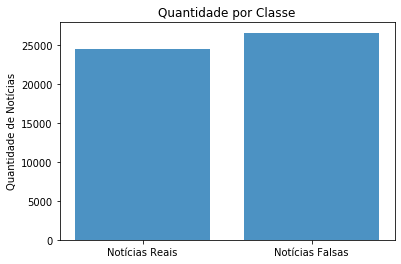

In [29]:
classes = ('Notícias Reais', 'Notícias Falsas')
y_pos = np.arange(len(classes))
performance = [df.label.value_counts().REAL, df.label.value_counts().FAKE]

plt.bar(y_pos, performance, align='center', alpha=0.8)
plt.xticks(y_pos,classes)
plt.ylabel('Quantidade de Notícias')
plt.title('Quantidade por Classe')
plt.show()

In [30]:
x = df['text']
y = df['label']

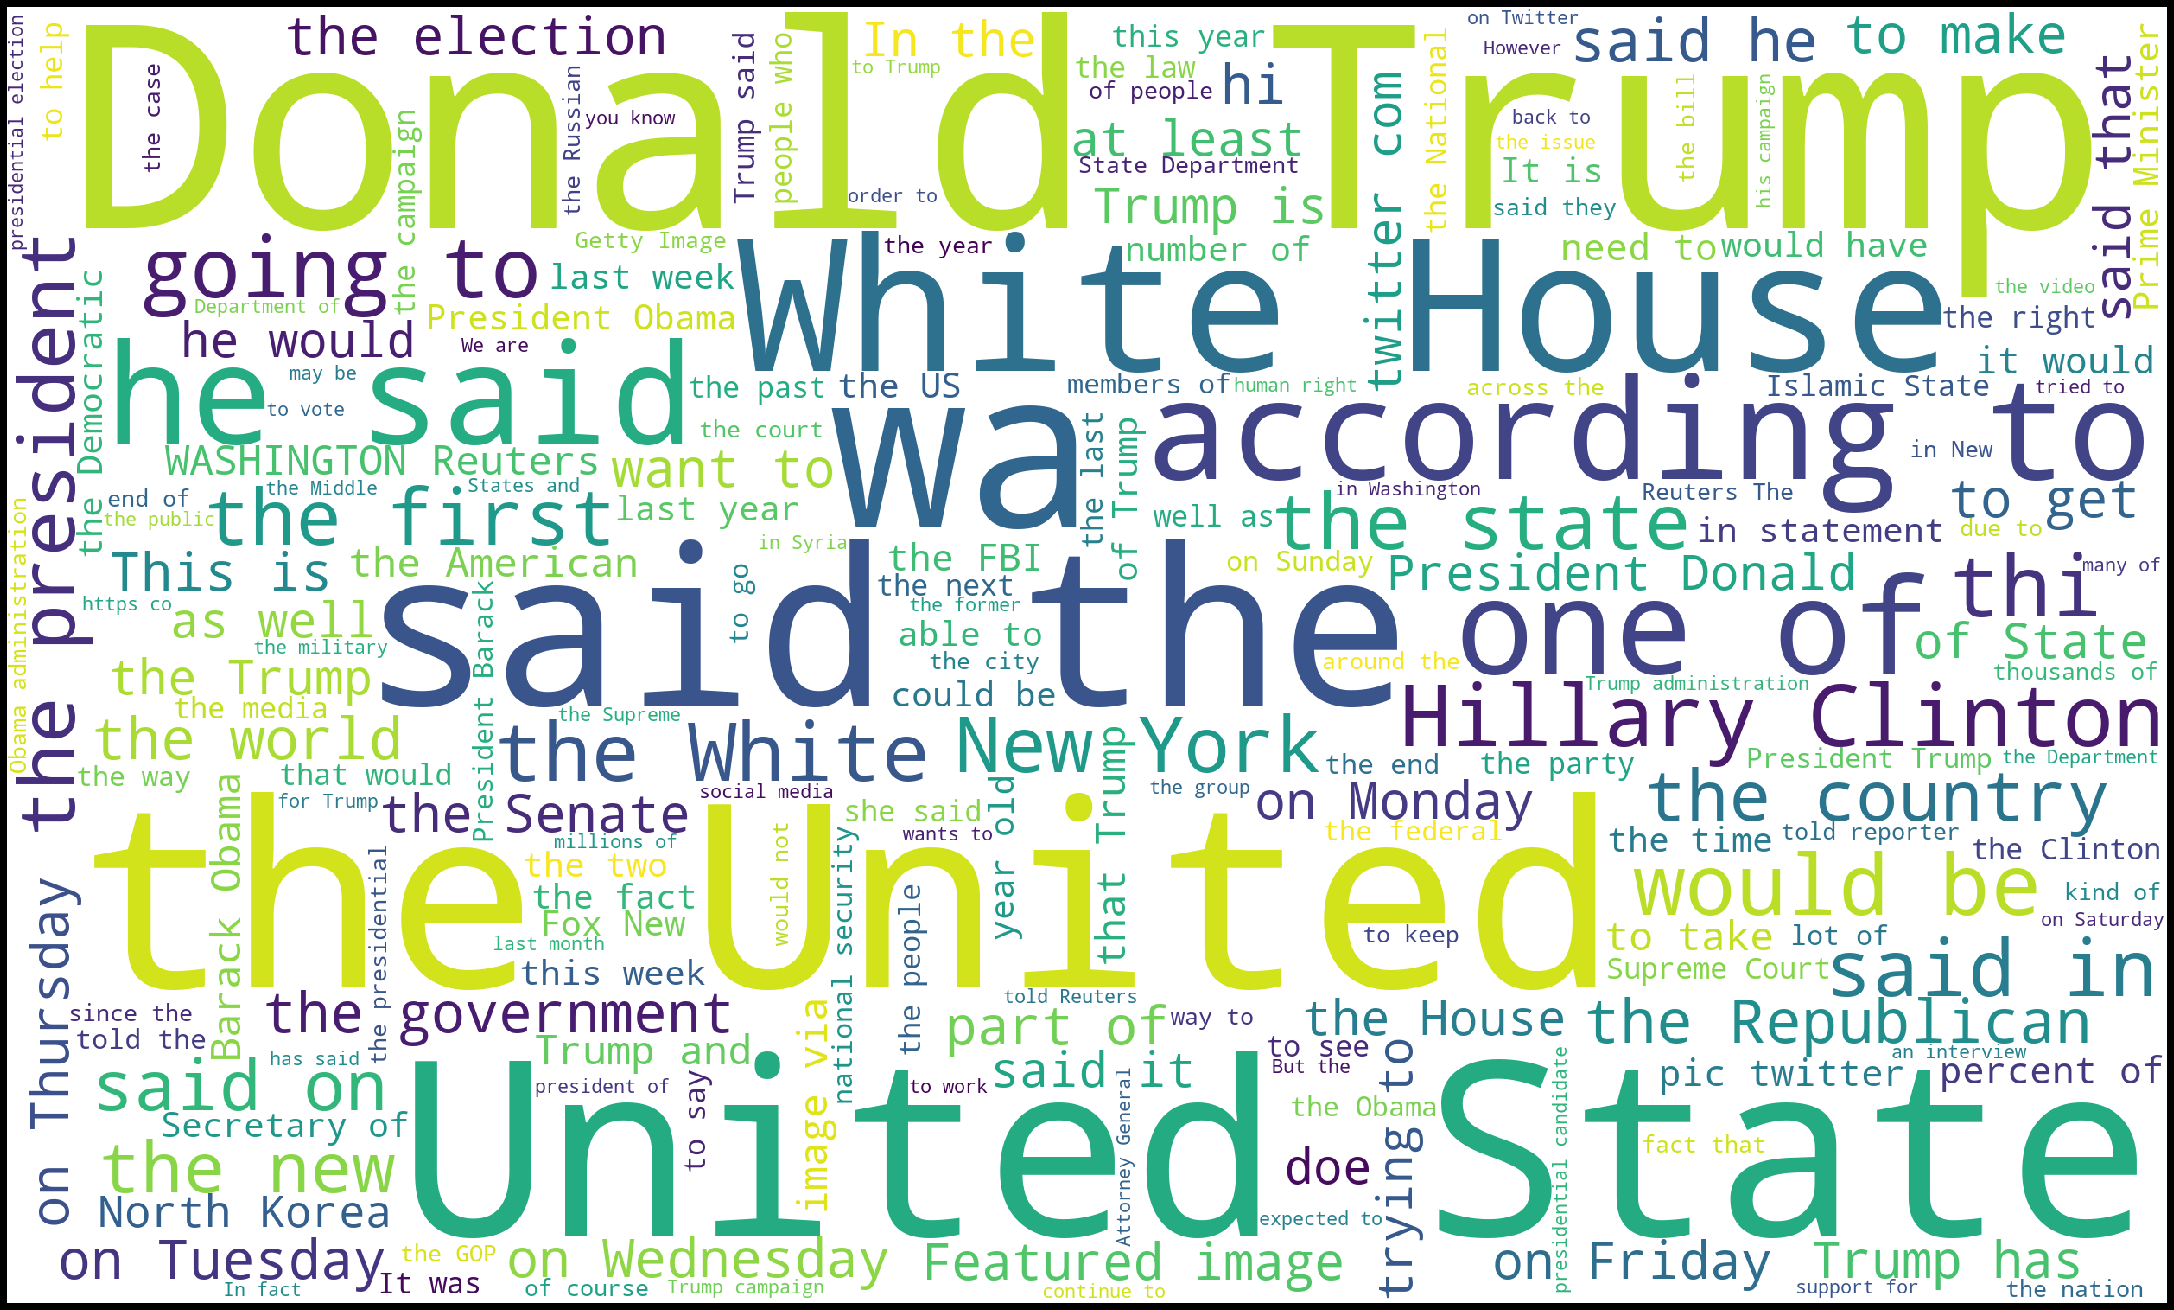

In [31]:
txt = df.text.str.cat(sep=' ')
wordcloud = WordCloud(width=2500, height=1500, background_color='white', 
                     stopwords = set(nltk.corpus.stopwords.words("english"))).generate(txt)
fig = plt.figure(figsize=(30,40), facecolor='k', edgecolor='k')
plt.imshow(wordcloud, interpolation='nearest')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del txt

In [32]:
#Segmentação da base de dados para treino e teste 
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=7)

# Tokenização com TfidfVectorizer

## nBayes

In [33]:
p_tf_nb = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                    ('nbmodel', MultinomialNB())])

In [34]:
#Training our data
p_tf_nb.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('nbmodel',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [35]:
#Predicting the label for the test data
pred_tf_nb = p_tf_nb.predict(x_test)

In [36]:
#Checking the performance of our model
print(classification_report(y_test, pred_tf_nb))
print(confusion_matrix(y_test, pred_tf_nb))

              precision    recall  f1-score   support

        FAKE       0.91      0.91      0.91      5390
        REAL       0.90      0.90      0.90      4857

    accuracy                           0.91     10247
   macro avg       0.91      0.91      0.91     10247
weighted avg       0.91      0.91      0.91     10247

[[4925  465]
 [ 484 4373]]


[[4925  465]
 [ 484 4373]]


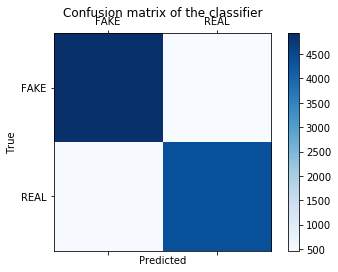

In [37]:
labels = ['FAKE', 'REAL']
cm = confusion_matrix(y_test, pred_tf_nb, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [38]:
#Calculando a acurácia do modelo
score = accuracy_score(y_test,pred_tf_nb)
print(f'Acurácia: {round(score*100,2)}%')

Acurácia: 90.74%


In [39]:
print(accuracy_score(pred_tf_nb, y_test))

0.9073875280569923


## DecisionTreeClassifier

In [40]:
p_tf_dt = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                    ('dtmodel', DecisionTreeClassifier())])

In [41]:
#Treinando o modelo
p_tf_dt.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('dtmodel',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
           

In [42]:
#Realizando a verificação com os dados de teste
pred_tf_dt = p_tf_dt.predict(x_test)

In [43]:
#Checando a performance do modelo
print(classification_report(y_test, pred_tf_dt))
print(confusion_matrix(y_test, pred_tf_dt))

              precision    recall  f1-score   support

        FAKE       0.95      0.97      0.96      5390
        REAL       0.96      0.94      0.95      4857

    accuracy                           0.95     10247
   macro avg       0.95      0.95      0.95     10247
weighted avg       0.95      0.95      0.95     10247

[[5211  179]
 [ 303 4554]]


[[5211  179]
 [ 303 4554]]


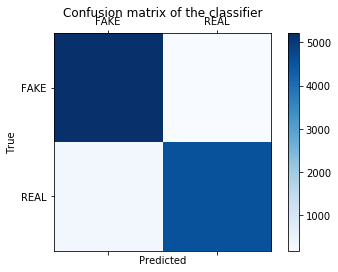

In [44]:
labels = ['FAKE', 'REAL']
cm = confusion_matrix(y_test, pred_tf_dt, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [46]:
#Calculando a acurácia do modelo
score = accuracy_score(y_test,pred_tf_dt)
print(f'Acurácia: {round(score*100,2)}%')

Acurácia: 95.3%


## SGDClassifier

In [47]:
p_tf_sgd = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                    ('sgdmodel', SGDClassifier())])

In [48]:
#Treinando o modelo
p_tf_sgd.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
           

In [49]:
#Realizando a verificação com os dados de teste
pred_tf_sgd = p_tf_sgd.predict(x_test)

In [50]:
#Checando a performance do modelo
print(classification_report(y_test, pred_tf_sgd))
print(confusion_matrix(y_test, pred_tf_sgd))

              precision    recall  f1-score   support

        FAKE       0.95      0.97      0.96      5390
        REAL       0.97      0.95      0.96      4857

    accuracy                           0.96     10247
   macro avg       0.96      0.96      0.96     10247
weighted avg       0.96      0.96      0.96     10247

[[5253  137]
 [ 254 4603]]


[[5253  137]
 [ 254 4603]]


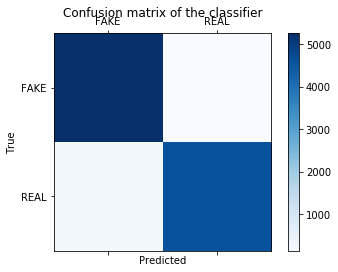

In [51]:
labels = ['FAKE', 'REAL']
cm = confusion_matrix(y_test, pred_tf_sgd, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [52]:
#Calculando a acurácia do modelo
score = accuracy_score(y_test,pred_tf_sgd)
print(f'Acurácia: {round(score*100,2)}%')

Acurácia: 96.18%


##  LinearSVC

In [53]:
p_tf_svc = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                    ('svcmodel', LinearSVC())])

In [54]:
#Treinando o modelo
p_tf_svc.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('svcmodel',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
     

In [55]:
#Realizando a verificação com os dados de teste
pred_tf_svc = p_tf_svc.predict(x_test)

In [56]:
#Checando a performance do modelo
print(classification_report(y_test, pred_tf_svc))
print(confusion_matrix(y_test, pred_tf_svc))

              precision    recall  f1-score   support

        FAKE       0.97      0.98      0.97      5390
        REAL       0.98      0.97      0.97      4857

    accuracy                           0.97     10247
   macro avg       0.97      0.97      0.97     10247
weighted avg       0.97      0.97      0.97     10247

[[5281  109]
 [ 165 4692]]


[[5281  109]
 [ 165 4692]]


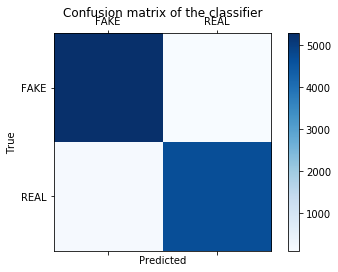

In [57]:
labels = ['FAKE', 'REAL']
cm = confusion_matrix(y_test, pred_tf_svc, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [58]:
#Calculando a acurácia do modelo
score = accuracy_score(y_test,pred_tf_svc)
print(f'Acurácia: {round(score*100,2)}%')

Acurácia: 97.33%


# Tokenização com CountVectorizer

## nBayes

In [59]:
p_cv_nb = Pipeline([('countvec', CountVectorizer(stop_words='english')),
                    ('nbmodel', MultinomialNB())])

In [60]:
#Treinando o modelo
p_cv_nb.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('countvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('nbmodel',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [61]:
#Realizando a verificação com os dados de teste
pred_cv_nb = p_cv_nb.predict(x_test)

In [62]:
#Checando a performance do modelo
print(classification_report(y_test, pred_cv_nb))
print(confusion_matrix(y_test, pred_cv_nb))

              precision    recall  f1-score   support

        FAKE       0.93      0.92      0.93      5390
        REAL       0.91      0.92      0.92      4857

    accuracy                           0.92     10247
   macro avg       0.92      0.92      0.92     10247
weighted avg       0.92      0.92      0.92     10247

[[4973  417]
 [ 387 4470]]


[[4973  417]
 [ 387 4470]]


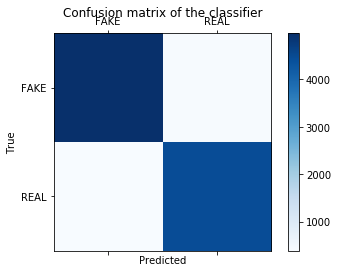

In [63]:
labels = ['FAKE', 'REAL']
cm = confusion_matrix(y_test, pred_cv_nb, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [64]:
#Calculando a acurácia do modelo
score = accuracy_score(y_test,pred_cv_nb)
print(f'Acurácia: {round(score*100,2)}%')

Acurácia: 92.15%


## DecisionTreeClassifier

In [65]:
p_cv_dt = Pipeline([('countvec', CountVectorizer(stop_words='english')),
                    ('dtmodel', DecisionTreeClassifier())])

In [66]:
#Treinando o modelo
p_cv_dt.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('countvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('dtmodel',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
   

In [67]:
#Realizando a verificação com os dados de teste
pred_cv_dt = p_cv_dt.predict(x_test)

In [68]:
#Checando a performance do modelo
print(classification_report(y_test, pred_cv_dt))
print(confusion_matrix(y_test, pred_cv_dt))

              precision    recall  f1-score   support

        FAKE       0.95      0.97      0.96      5390
        REAL       0.97      0.94      0.95      4857

    accuracy                           0.96     10247
   macro avg       0.96      0.96      0.96     10247
weighted avg       0.96      0.96      0.96     10247

[[5232  158]
 [ 274 4583]]


[[5232  158]
 [ 274 4583]]


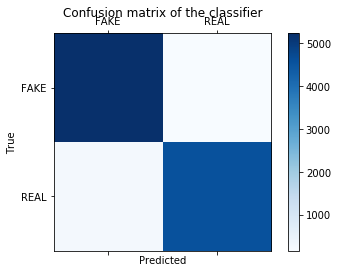

In [69]:
labels = ['FAKE', 'REAL']
cm = confusion_matrix(y_test, pred_cv_dt, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [70]:
#Calculando a acurácia do modelo
score = accuracy_score(y_test,pred_cv_dt)
print(f'Acurácia: {round(score*100,2)}%')

Acurácia: 95.78%


## SGDClassifier

In [71]:
p_cv_sgd = Pipeline([('countvec', CountVectorizer(stop_words='english')),
                    ('dtmodel', SGDClassifier())])

In [72]:
#Treinando o modelo
p_cv_sgd.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('countvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocab...
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000,

In [73]:
#Realizando a verificação com os dados de teste
pred_cv_sgd = p_cv_sgd.predict(x_test)

In [74]:
#Checando a performance do modelo
print(classification_report(y_test, pred_cv_sgd))
print(confusion_matrix(y_test, pred_cv_sgd))

              precision    recall  f1-score   support

        FAKE       0.95      0.98      0.97      5390
        REAL       0.98      0.95      0.96      4857

    accuracy                           0.97     10247
   macro avg       0.97      0.96      0.97     10247
weighted avg       0.97      0.97      0.97     10247

[[5293   97]
 [ 259 4598]]


[[5293   97]
 [ 259 4598]]


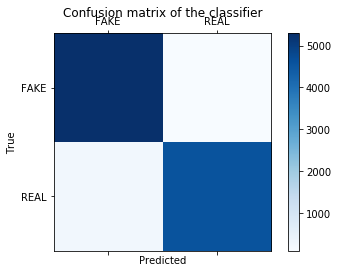

In [75]:
labels = ['FAKE', 'REAL']
cm = confusion_matrix(y_test, pred_cv_sgd, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [76]:
#Calculando a acurácia do modelo
score = accuracy_score(y_test,pred_cv_sgd)
print(f'Acurácia: {round(score*100,2)}%')

Acurácia: 96.53%


## LinearSVC

In [77]:
p_cv_svc = Pipeline([('countvec', CountVectorizer(stop_words='english')),
                    ('svcmodel', MultinomialNB())])

In [78]:
#Treinando o modelo
p_cv_svc.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('countvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('svcmodel',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [79]:
#Realizando a verificação com os dados de teste
pred_cv_svc = p_cv_svc.predict(x_test)

In [80]:
#Checando a performance do modelo
print(classification_report(y_test, pred_cv_svc))
print(confusion_matrix(y_test, pred_cv_svc))

              precision    recall  f1-score   support

        FAKE       0.93      0.92      0.93      5390
        REAL       0.91      0.92      0.92      4857

    accuracy                           0.92     10247
   macro avg       0.92      0.92      0.92     10247
weighted avg       0.92      0.92      0.92     10247

[[4973  417]
 [ 387 4470]]


accuracy:   0.922
[[4973  417]
 [ 387 4470]]


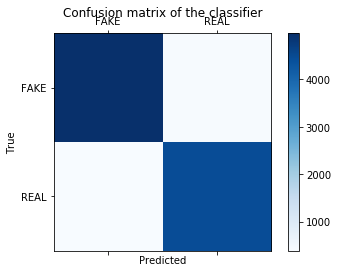

In [81]:
labels = ['FAKE', 'REAL']
score = accuracy_score(y_test, pred_cv_svc)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred_cv_svc, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [82]:
#Calculando a acurácia do modelo
score = accuracy_score(y_test,pred_cv_svc)
print(f'Acurácia: {round(score*100,2)}%')

Acurácia: 92.15%
